## Setup

In [1]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
from sklearn.metrics import mean_absolute_error


## Prepare the data

### Download and prepare the DataFrames

First, let's download the movielens data.

The downloaded folder will contain three data files: `users.dat`, `movies.dat`,
and `ratings.dat`.

In [2]:
import pandas as pd
from io import StringIO

# Read the file as binary data
with open("ml-1m/movies.dat", "rb") as file:
    data = file.read()

# Decode the data while ignoring invalid characters
data_str = data.decode('utf-8', errors='ignore')

# Create a StringIO object to read the decoded data
data_io = StringIO(data_str)

# Read the data into a DataFrame
movies = pd.read_csv(
    data_io,
    sep="::",
    names=["movie_id", "title", "genres"],
    engine='python'
)


In [3]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Then, we load the data into pandas DataFrames with their proper column names.

In [4]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

/var/folders/l2/_mks1sd56yjdxq9514qt1fnh0000gn/T/ipykernel_9168/3511900228.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(
/var/folders/l2/_mks1sd56yjdxq9514qt1fnh0000gn/T/ipykernel_9168/3511900228.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(


Here, we do some simple data processing to fix the data types of the columns.

In [5]:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Each movie has multiple genres. We split them into separate columns in the `movies`
DataFrame.

In [6]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )


In [7]:
movies["title"].value_counts()

title
Toy Story (1995)                           1
Buena Vista Social Club (1999)             1
Son of Frankenstein (1939)                 1
Ghost of Frankenstein, The (1942)          1
Frankenstein Meets the Wolf Man (1943)     1
                                          ..
Kids of Survival (1993)                    1
Alien (1992)                               1
American Werewolf in London, An (1981)     1
Amityville 1992: It's About Time (1992)    1
Contender, The (2000)                      1
Name: count, Length: 3883, dtype: int64

### Transform the movie ratings data into sequences

First, let's sort the the ratings data using the `unix_timestamp`, and then group the
`movie_id` values and the `rating` values by `user_id`.

The output DataFrame will have a record for each `user_id`, with two ordered lists
(sorted by rating datetime): the movies they have rated, and their ratings of these movies.

In [8]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)


In [9]:
ratings_data

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."
3,user_1000,"[movie_971, movie_260, movie_2990, movie_2973,...","[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...","[975040566, 975040566, 975040566, 975040629, 9..."
4,user_1001,"[movie_1198, movie_1617, movie_2885, movie_390...","[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0, ...","[975039591, 975039702, 975039702, 975039898, 9..."
...,...,...,...,...
6035,user_995,"[movie_1894, movie_260, movie_247, movie_433, ...","[2.0, 4.0, 5.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, ...","[975054785, 975054785, 975054785, 975054853, 9..."
6036,user_996,"[movie_1347, movie_2146, movie_1961, movie_274...","[4.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, ...","[975052132, 975052132, 975052195, 975052284, 9..."
6037,user_997,"[movie_1196, movie_2082, movie_3247, movie_244...","[4.0, 3.0, 3.0, 3.0, 2.0, 5.0, 5.0, 5.0, 4.0, ...","[975044235, 975044425, 975044426, 975044426, 9..."
6038,user_998,"[movie_2266, movie_1264, movie_1097, movie_164...","[3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, ...","[975043499, 975043593, 975043593, 975043593, 9..."


Now, let's split the `movie_ids` list into a set of sequences of a fixed length.
We do the same for the `ratings`. Set the `sequence_length` variable to change the length
of the input sequence to the model. You can also change the `step_size` to control the
number of sequences to generate for each user.

In [10]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

In [11]:
ratings_data

,user_id,movie_ids,ratings
0,user_1,"[[movie_3186, movie_1721, movie_1270, movie_10...","[[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [..."
1,user_10,"[[movie_597, movie_858, movie_743, movie_1210]...","[[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [..."
2,user_100,"[[movie_260, movie_1676, movie_1198, movie_541...","[[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [..."
3,user_1000,"[[movie_971, movie_260, movie_2990, movie_2973...","[[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [..."
4,user_1001,"[[movie_1198, movie_1617, movie_2885, movie_39...","[[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [..."
...,...,...,...
6035,user_995,"[[movie_1894, movie_260, movie_247, movie_433]...","[[2.0, 4.0, 5.0, 3.0], [5.0, 3.0, 3.0, 4.0], [..."
6036,user_996,"[[movie_1347, movie_2146, movie_1961, movie_27...","[[4.0, 3.0, 5.0, 3.0], [5.0, 3.0, 5.0, 5.0], [..."
6037,user_997,"[[movie_1196, movie_2082, movie_3247, movie_24...","[[4.0, 3.0, 3.0, 3.0], [3.0, 3.0, 2.0, 5.0], [..."
6038,user_998,"[[movie_2266, movie_1264, movie_1097, movie_16...","[[3.0, 4.0, 5.0, 5.0], [5.0, 5.0, 4.0, 3.0], [..."


After that, we process the output to have each sequence in a separate records in
the DataFrame. In addition, we join the user features with the ratings data.

In [12]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [13]:
len(ratings_data_transformed.columns)

6

With `sequence_length` of 4 and `step_size` of 2, we end up with 498,623 sequences.

Finally, we split the data into training and testing splits, with 85% and 15% of
the instances, respectively, and store them to CSV files.

In [14]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

## Define metadata

In [15]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

## Create `tf.data.Dataset` for training and evaluation

In [16]:

def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset


## Create model inputs

In [17]:

def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }


## Encode input features

The `encode_input_features` method works as follows:

1. Each categorical user feature is encoded using `layers.Embedding`, with embedding
dimension equals to the square root of the vocabulary size of the feature.
The embeddings of these features are concatenated to form a single input tensor.

2. Each movie in the movie sequence and the target movie is encoded `layers.Embedding`,
where the dimension size is the square root of the number of movies.

3. A multi-hot genres vector for each movie is concatenated with its embedding vector,
and processed using a non-linear `layers.Dense` to output a vector of the same movie
embedding dimensions.

4. A positional embedding is added to each movie embedding in the sequence, and then
multiplied by its rating from the ratings sequence.

5. The target movie embedding is concatenated to the sequence movie embeddings, producing
a tensor with the shape of `[batch size, sequence length, embedding size]`, as expected
by the attention layer for the transformer architecture.

6. The method returns a tuple of two elements:  `encoded_transformer_features` and
`encoded_other_features`.

In [18]:

def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features


## Create a BST model

In [19]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


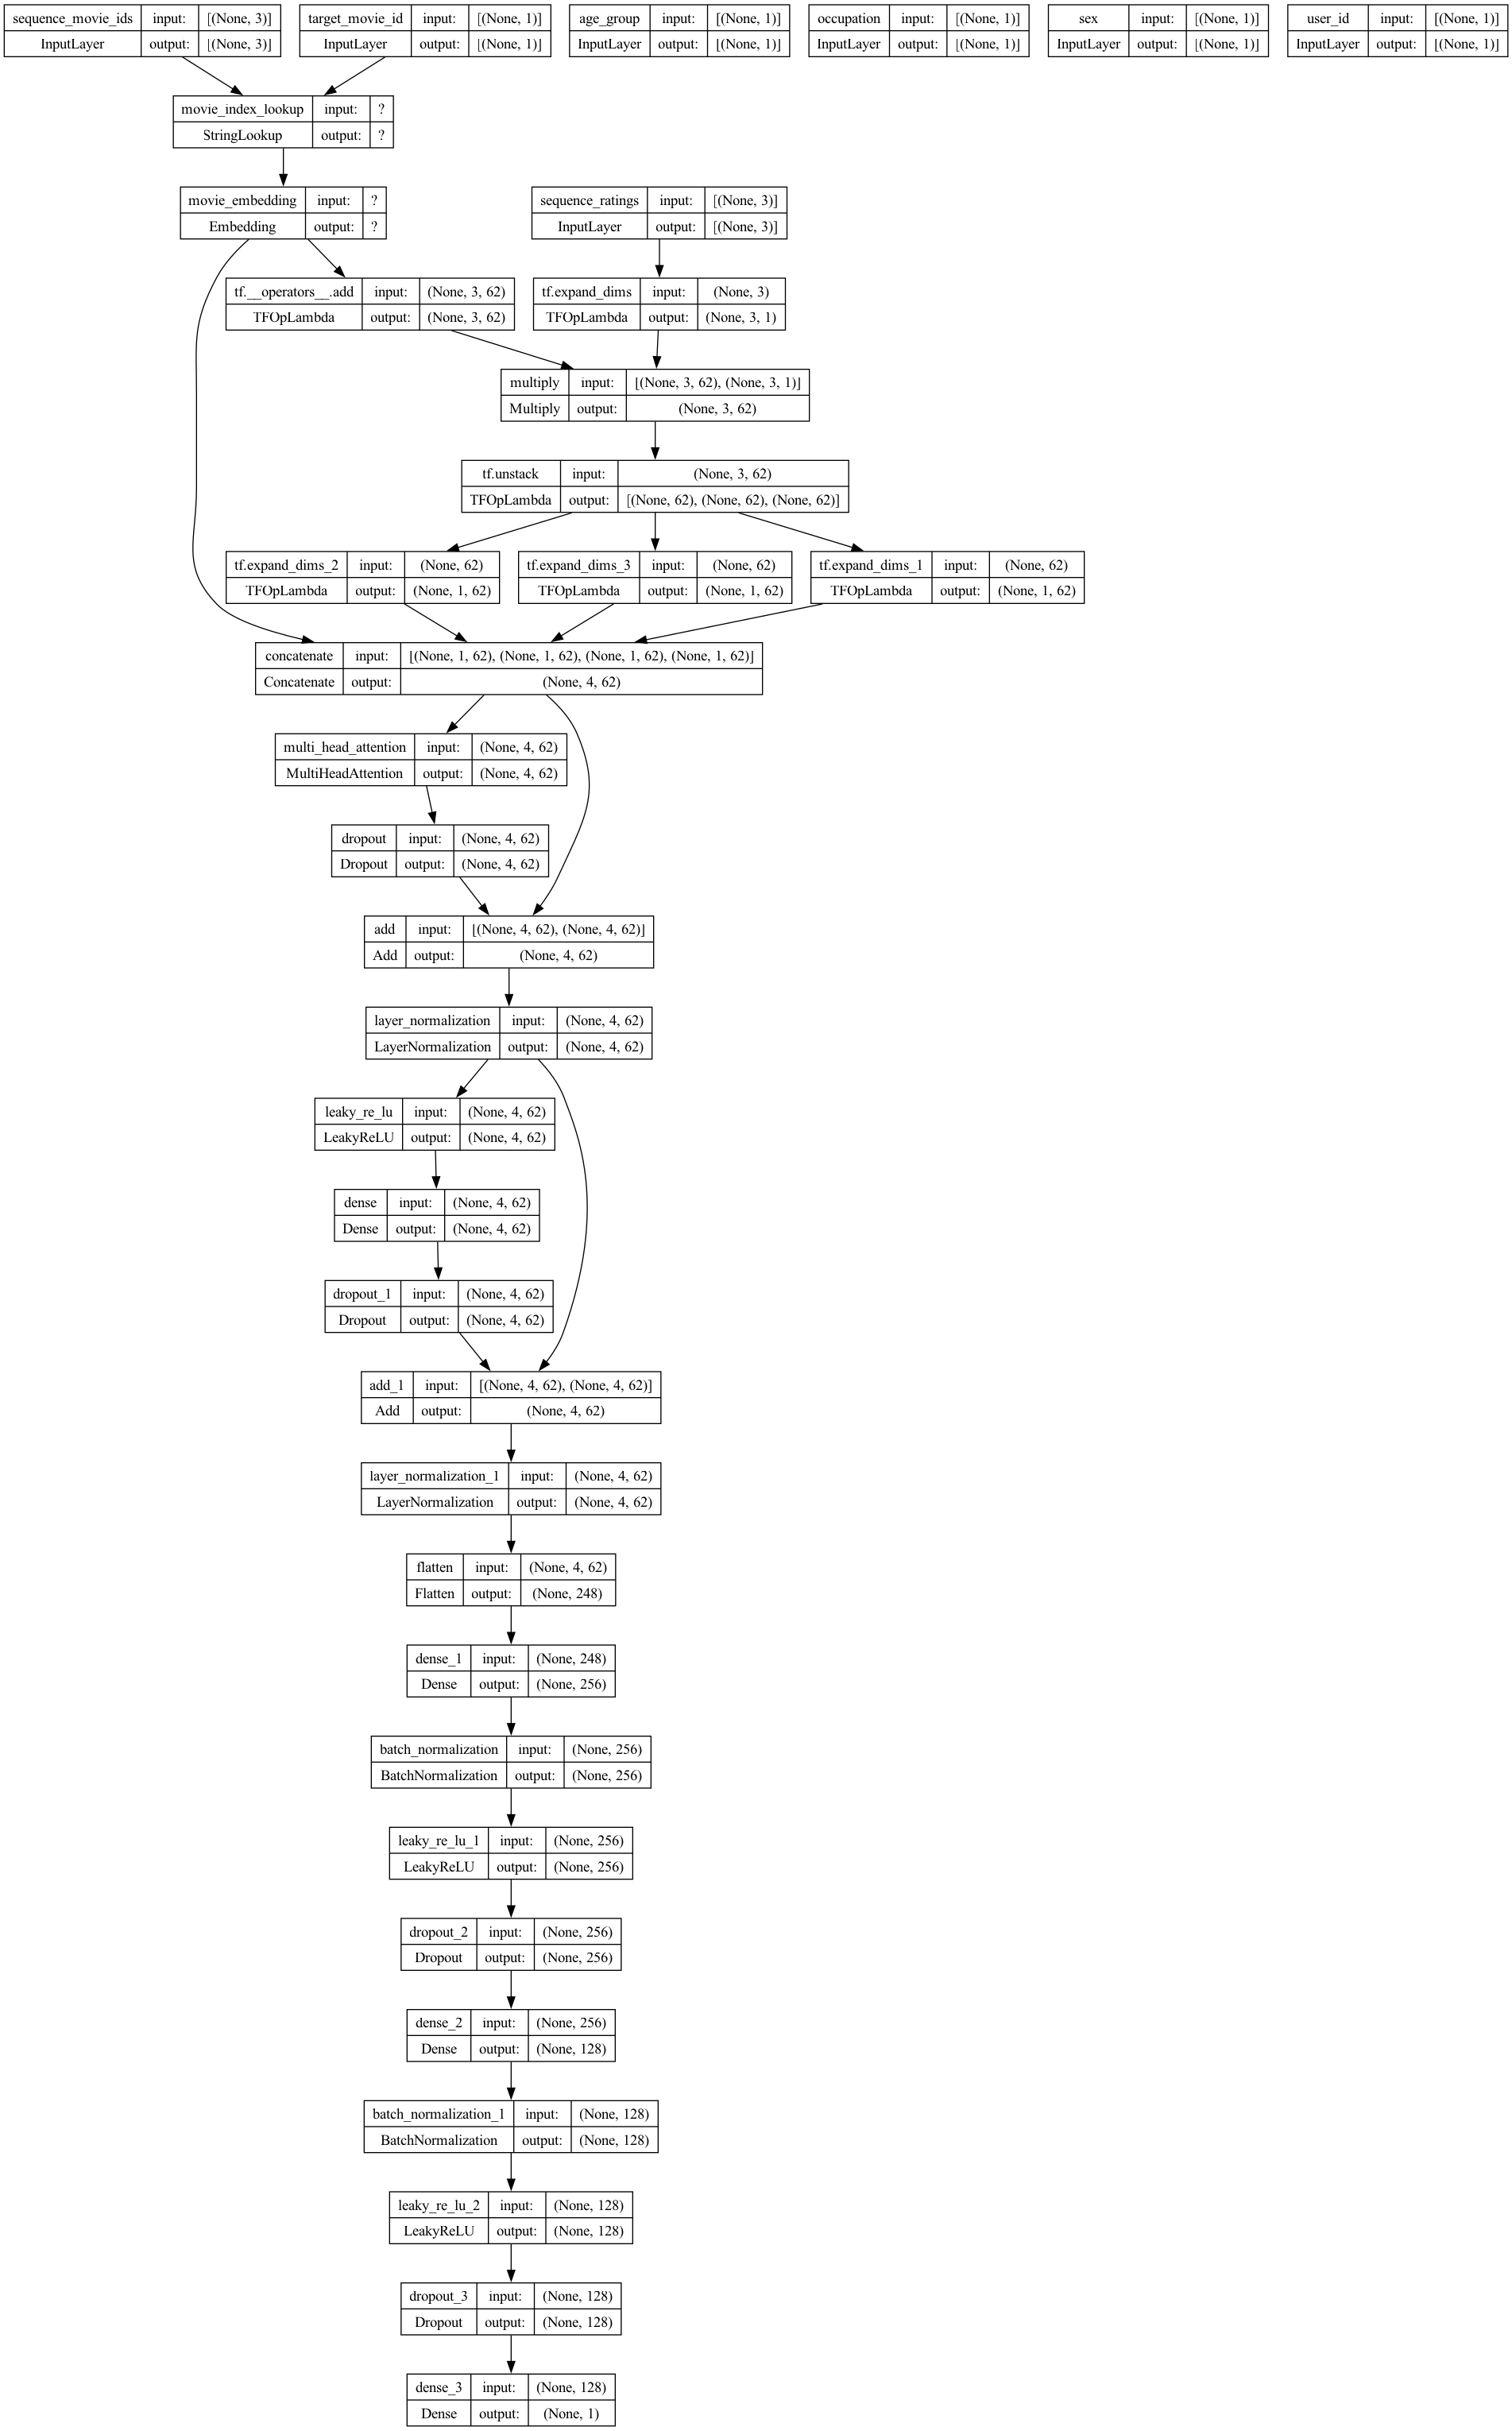

In [20]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your Keras modelz
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## Run training and evaluation experiment

In [21]:
NUM_ROUNDS = 10
NUM_CLIENTS = 10
BATCH_SIZE = 10
EPOCHS_PER_ROUND = 10
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-7

In [22]:
from keras.src.metrics.regression_metrics import MeanAbsoluteError
from keras.src.metrics.regression_metrics import MeanAbsolutePercentageError
from keras.src.metrics.regression_metrics import MeanRelativeError
from keras.src.metrics.regression_metrics import MeanSquaredError
from keras.src.metrics.regression_metrics import MeanSquaredLogarithmicError
from keras.src.metrics.regression_metrics import R2Score
from keras.src.metrics.regression_metrics import RootMeanSquaredError

In [24]:
import tensorflow as tf
from tensorflow import keras

# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.MeanSquaredError(),
    metrics=[RootMeanSquaredError(),R2Score(),MeanSquaredLogarithmicError(),MeanSquaredError(),MeanRelativeError(),MeanAbsolutePercentageError(),MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=256)

# Initialize an empty list to store the training loss
training_losses = []

# Define a custom callback to capture training loss
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_losses.append(logs['loss'])

# Fit the model with the training data and capture the training loss
history_callback = model.fit(train_dataset, epochs=2, callbacks=[LossHistory()])

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=256)

# Initialize an empty list to store the test losses
test_losses = []

# Define a custom callback to capture test loss
class TestLossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss = model.evaluate(test_dataset, verbose=0)
        test_losses.append(test_loss[0])

# Use the TestLossHistory callback to evaluate the model on the test dataset
test_loss_callback = TestLossHistory()
test_loss_callback.on_epoch_end(0)  # You can call it after each epoch if needed

# Print the test losses
print("Test Losses:")
print(test_losses[0])
for epoch, test_loss in enumerate(test_losses, 1):
    print(f"Epoch {epoch}: Test Loss = {test_loss:.4f}")


Epoch 1/2


2023-12-19 14:26:35.660288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


1656/1656 [==============================] - 118s 69ms/step - loss: 1.1043 - root_mean_squared_error: 1.0508 - r2_score: 0.1145 - mean_squared_logarithmic_error: 0.0720
Epoch 2/2
1656/1656 [==============================] - 108s 65ms/step - loss: 1.0043 - root_mean_squared_error: 1.0022 - r2_score: 0.1947 - mean_squared_logarithmic_error: 0.0654
Test Losses:
1.1491681337356567
Epoch 1: Test Loss = 1.1492


In [41]:
x_train_clients = np.array_split(pd.read_csv("train_data.csv"),NUM_CLIENTS)
x_test_clients = np.array_split(pd.read_csv("test_data.csv"),NUM_CLIENTS)
if not os.path.exists("client_data"):
    os.mkdir("client_data")
    os.mkdir("client_data/train_clients")
    os.mkdir("client_data/test_clients")
for i in range(0, NUM_CLIENTS):
    train_filename = f"client_data/train_clients/train_{i + 1}.csv"
    test_filename = f"client_data/test_clients/test_{i + 1}.csv"

    x_train_clients[i].to_csv(train_filename, index=False)
    x_test_clients[i].to_csv(test_filename, index=False)


In [23]:
# SERVER ADAM OPTIMIZER
fedadam = tf.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=BETA_1,beta_2 = BETA_2,epsilon=EPSILON)

In [24]:
global_model = create_model()
# Compile the model.
global_model.compile(
    optimizer=fedadam,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [25]:
z = [1,2,3,4]
z[1:]

[2, 3, 4]

In [26]:
client_losses = []
client_train_losses = []

client_mae = []
global_maes = []

client_models = []
for i in range(NUM_CLIENTS):
    train_losses = []
    test_losses = []
    local_model = create_model()
    local_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=keras.losses.MeanSquaredError(),
        metrics=[RootMeanSquaredError(),R2Score(),MeanSquaredLogarithmicError(),MeanSquaredError(),MeanAbsolutePercentageError(),MeanAbsoluteError()],
    )
    train_dataset = get_dataset_from_csv(f"client_data/train_clients/train_{i + 1}.csv", shuffle=True, batch_size=BATCH_SIZE)
    test_dataset = get_dataset_from_csv(f"client_data/test_clients/test_{i + 1}.csv", shuffle=True, batch_size=BATCH_SIZE)
    
    local_model.fit(train_dataset,epochs=EPOCHS_PER_ROUND, batch_size=BATCH_SIZE,verbose=0)
    
    training_losses = []
    # Define a custom callback to capture training loss
    class LossHistory(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            training_losses.append(logs['loss'])
            
    evaluation = local_model.evaluate(test_dataset)
    client_train_losses.append(train_losses)
    client_mae.append(evaluation[1:])
    client_models.append(local_model)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 18:01:06.351866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 18s 23ms/step - loss: 1.1570 - root_mean_squared_error: 1.0756 - r2_score: 0.1313 - mean_squared_logarithmic_error: 0.0741 - mean_squared_error: 1.1570 - mean_absolute_percentage_error: 34.0556 - mean_absolute_error: 0.8855


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 18:26:43.028990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 18s 23ms/step - loss: 1.0974 - root_mean_squared_error: 1.0476 - r2_score: 0.1107 - mean_squared_logarithmic_error: 0.0717 - mean_squared_error: 1.0974 - mean_absolute_percentage_error: 33.8851 - mean_absolute_error: 0.8393


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 18:53:10.108985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 16s 20ms/step - loss: 1.0769 - root_mean_squared_error: 1.0377 - r2_score: 0.1253 - mean_squared_logarithmic_error: 0.0694 - mean_squared_error: 1.0769 - mean_absolute_percentage_error: 32.8681 - mean_absolute_error: 0.8323


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 19:47:51.081264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 18s 22ms/step - loss: 1.1190 - root_mean_squared_error: 1.0578 - r2_score: 0.0840 - mean_squared_logarithmic_error: 0.0692 - mean_squared_error: 1.1190 - mean_absolute_percentage_error: 32.4465 - mean_absolute_error: 0.8691


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 20:13:06.173122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 17s 21ms/step - loss: 1.1570 - root_mean_squared_error: 1.0756 - r2_score: 0.1079 - mean_squared_logarithmic_error: 0.0748 - mean_squared_error: 1.1570 - mean_absolute_percentage_error: 34.4445 - mean_absolute_error: 0.8764


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 20:37:53.860008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 18s 22ms/step - loss: 1.0501 - root_mean_squared_error: 1.0247 - r2_score: 0.1319 - mean_squared_logarithmic_error: 0.0665 - mean_squared_error: 1.0501 - mean_absolute_percentage_error: 32.1512 - mean_absolute_error: 0.8352


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 21:03:44.566385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 16s 21ms/step - loss: 1.0587 - root_mean_squared_error: 1.0289 - r2_score: 0.1179 - mean_squared_logarithmic_error: 0.0690 - mean_squared_error: 1.0587 - mean_absolute_percentage_error: 32.8493 - mean_absolute_error: 0.8225


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 21:29:50.159176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


746/746 [==============================] - 17s 22ms/step - loss: 1.0933 - root_mean_squared_error: 1.0456 - r2_score: 0.0958 - mean_squared_logarithmic_error: 0.0681 - mean_squared_error: 1.0933 - mean_absolute_percentage_error: 32.1479 - mean_absolute_error: 0.8467


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2023-12-20 21:55:09.969985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


In [ ]:
client_mae[0]

[1.0601249933242798,
 0.16763460636138916,
 0.07599300891160965,
 1.1238651275634766,
 35.57461166381836,
 0.8586732149124146]

In [47]:
data = client_mae
column_names = ["RootMeanSquaredError","R2Score","MeanSquaredLogarithmicError","MeanSquaredError","MeanAbsolutePercentageError","MeanAbsoluteError"]
df1 = pd.DataFrame(data, columns=column_names)
df1.to_csv('results_bst.csv')

: 

In [33]:
# Performing Federated Averaging
weights = global_model.get_weights()
for i in range(len(weights)):
    for j in range(NUM_CLIENTS):
        client_weights = client_models[j].get_weights()
        weights[i] += client_weights[i]/NUM_CLIENTS

global_model.set_weights(weights)

In [34]:
valid = train_dataset = get_dataset_from_csv("valid_data.csv", shuffle=True, batch_size=BATCH_SIZE)
mae = global_model.evaluate(valid)
print(mae)

21/21 [==============================] - 3s 122ms/step - loss: 2.0532 - mean_absolute_error: 1.2194
1.219400405883789


ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

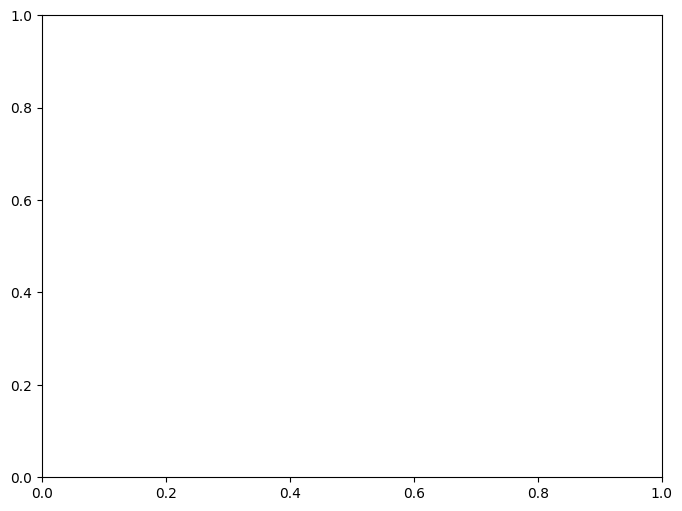

In [50]:

import matplotlib.pyplot as plt

num_clients = list(range(1, NUM_CLIENTS + 1))
fig, ax = plt.subplots(figsize=(8, 6))

# Plot global accuracy and MAE
ax.plot(num_clients, client_mae, marker='o', linestyle='-', color='y', label='Client MAE')
ax.set_xlabel('Num Rounds')
ax.set_ylabel('Accuracy and MAE')
ax.grid(True)

# Add legend
ax.legend()

# Save the combined plot
plt.savefig("global_metrics.png")

You should achieve a Mean Absolute Error (MAE) at or around 0.7 on the test data.

## Conclusion

The BST model uses the Transformer layer in its architecture to capture the sequential signals underlying
users’ behavior sequences for recommendation.

You can try training this model with different configurations, for example, by increasing
the input sequence length and training the model for a larger number of epochs. In addition,
you can try including other features like movie release year and customer
zipcode, and including cross features like sex X genre.